# test_quasar8_clean3_getdist_overlay

Load scenario-2 and scenario-3 `.nc` files from clean-only parent500 runs,
and plot a 2D overlay contour for `H0` vs posterior `lambda_mean` using `getdist`.

Plot styling:
- Filled contour: `TD + DSPL` (red)
- Line contour: `TD lenses` (grey)
- Add vertical reference bands for Planck CMB and SH0ES H0 constraints.


In [1]:
from pathlib import Path

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from getdist import MCSamples, plots

cwd = Path.cwd().resolve()
repo_root = None
if (cwd / 'slcosmo').is_dir() and (cwd / 'test').is_dir():
    repo_root = cwd
elif (cwd / 'LensedUniverse' / 'test').is_dir():
    repo_root = cwd / 'LensedUniverse'
else:
    for candidate in [cwd, *cwd.parents]:
        if (candidate / 'test').is_dir() and (candidate / 'data').is_dir():
            repo_root = candidate
            break

if repo_root is None:
    raise RuntimeError(f'Cannot locate LensedUniverse repo root from cwd={cwd}')

TEST_DIR = repo_root / 'test'
print('Repo root:', repo_root)
print('Test dir:', TEST_DIR)


Repo root: /users/tianli/LensedUniverse
Test dir: /users/tianli/LensedUniverse/test


In [2]:
# Scenario-2 and Scenario-3 netcdf files
nc_s2 = TEST_DIR / 'test_quasar8_clean3_individual_mst_8pct.nc'
nc_s3 = TEST_DIR / 'test_quasar8_clean3_parent500_no_individual.nc'

idata_s2 = az.from_netcdf(nc_s2)
idata_s3 = az.from_netcdf(nc_s3)

# h0 samples
h0_s2 = np.asarray(idata_s2.posterior['h0'].values).reshape(-1)
h0_s3 = np.asarray(idata_s3.posterior['h0'].values).reshape(-1)

# lambda_mean posterior samples
lambda_mean_s2 = np.asarray(idata_s2.posterior['lambda_mean'].values).reshape(-1)
lambda_mean_s3 = np.asarray(idata_s3.posterior['lambda_mean'].values).reshape(-1)

print('Scenario-2 samples:', h0_s2.size)
print('Scenario-3 samples:', h0_s3.size)
print('S2 H0 median:', float(np.median(h0_s2)), 'lambda_mean median:', float(np.median(lambda_mean_s2)))
print('S3 H0 median:', float(np.median(h0_s3)), 'lambda_mean median:', float(np.median(lambda_mean_s3)))


Scenario-2 samples: 4000
Scenario-3 samples: 4000
S2 H0 median: 72.9290771484375 lambda_mean median: 0.9953309893608093
S3 H0 median: 73.29825592041016 lambda_mean median: 0.9999690651893616


Removed no burn in
Removed no burn in


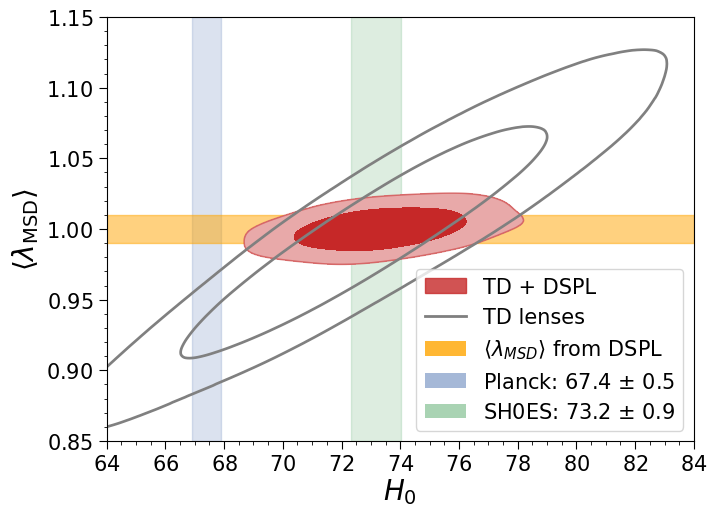

Saved: /users/tianli/LensedUniverse/test/test_quasar8_clean3_lambda_mean_vs_h0_getdist.png
Saved: /users/tianli/LensedUniverse/test/test_quasar8_clean3_lambda_mean_vs_h0_getdist.pdf


In [6]:
# Build getdist samples (2D only, no 1D histograms)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Reference values from literature:
# Planck 2018 (base-LCDM): H0 = 67.4 +/- 0.5 km/s/Mpc
# SH0ES (SMC anchor update): H0 = 73.17 +/- 0.86 km/s/Mpc
planck_h0 = 67.4
planck_h0_err = 0.5
sh0es_h0 = 73.17
sh0es_h0_err = 0.86

# DSPL prior-equivalent region on <lambda_MSD>
lambda_dspl = 1.0
lambda_dspl_err = 0.01

# Scenario mapping for display
# Here we follow user-requested labels for the overlay figure.
s_td_lenses = MCSamples(
    samples=np.column_stack([h0_s2, lambda_mean_s2]),
    names=['H0', 'lambda_mean'],
    labels=[r'H_0', r'\langle\lambda_{\rm MSD}\rangle'],
    label='TD lenses',
)

s_td_dspl = MCSamples(
    samples=np.column_stack([h0_s3, lambda_mean_s3]),
    names=['H0', 'lambda_mean'],
    labels=[r'H_0', r'\langle\lambda_{\rm MSD}\rangle'],
    label='TD + DSPL',
)

g = plots.get_single_plotter(width_inch=6.8)
g.plot_2d(
    [s_td_dspl, s_td_lenses],
    'H0',
    'lambda_mean',
    filled=[True, False],
    colors=['#c62828', 'grey'],
)

ax = g.fig.axes[0]

# Vertical reference bands
ax.axvspan(planck_h0 - planck_h0_err, planck_h0 + planck_h0_err, color='#4c72b0', alpha=0.2, zorder=0)
ax.axvspan(sh0es_h0 - sh0es_h0_err, sh0es_h0 + sh0es_h0_err, color='#55a868', alpha=0.2, zorder=0)

# Horizontal DSPL band on <lambda_MSD>
ax.axhspan(lambda_dspl - lambda_dspl_err, lambda_dspl + lambda_dspl_err, color='orange', alpha=0.5, zorder=0)

# Axis ranges and ticks
ax.set_xlim(64.0, 84.0)
ax.set_ylim(0.85, 1.15)
ax.set_xticks(np.arange(64.0, 84.1, 2.0))
ax.set_yticks(np.arange(0.85, 1.151, 0.05))
ax.minorticks_on()
ax.tick_params(axis='x', which='major', labelsize=15, length=6)
ax.tick_params(axis='x', which='minor', length=3)
ax.tick_params(axis='y', which='major', labelsize=15, length=6)

ax.set_xlabel(r'$H_0$', fontsize=20)
ax.set_ylabel(r'$\langle\lambda_{\rm MSD}\rangle$', fontsize=20)

# Custom legend
legend_handles = [
    Patch(facecolor='#c62828', edgecolor='#c62828', alpha=0.8, label='TD + DSPL'),
    Line2D([0], [0], color='#7f7f7f', lw=2.0, label='TD lenses'),
    Patch(facecolor='orange', edgecolor='none', alpha=0.8, label=r'$\langle\lambda_{MSD}\rangle$ from DSPL'),
    Patch(facecolor='#4c72b0', edgecolor='none', alpha=0.5, label=r'Planck: 67.4 $\pm$ 0.5'),
    Patch(facecolor='#55a868', edgecolor='none', alpha=0.5, label=r'SH0ES: 73.2 $\pm$ 0.9'),
]
ax.legend(handles=legend_handles, loc='lower right', fontsize=15, frameon=True)

png_out = TEST_DIR / 'test_quasar8_clean3_lambda_mean_vs_h0_getdist.png'
pdf_out = TEST_DIR / 'test_quasar8_clean3_lambda_mean_vs_h0_getdist.pdf'
g.fig.savefig(png_out, dpi=220, bbox_inches='tight')
g.fig.savefig(pdf_out, bbox_inches='tight')
plt.show()

print('Saved:', png_out)
print('Saved:', pdf_out)
